## MIXTURE DENSITY NETWORK from [HERE](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
%matplotlib inline
print ("PACKAGES LOADED")

PACKAGES LOADED


## SET TRAINING DATA

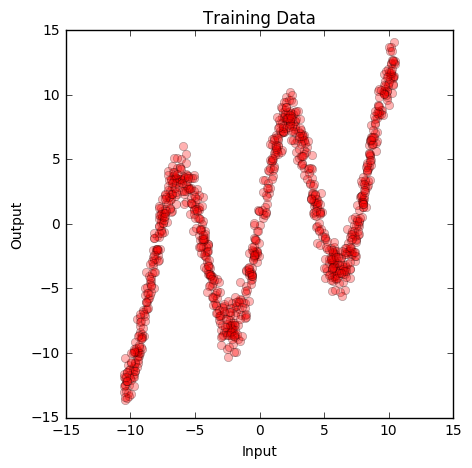

In [2]:
NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
y_data = np.float32(np.sin(0.75*x_data)*7.0 + x_data*0.5 + r_data*1.0)
# PLOT
plt.figure(figsize=(5, 5))
plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.title("Training Data")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

## TRAIN REGRESSION NETWORK

In [3]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])

NHIDDEN = 20
W = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
}
b = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))
}
def mlp(_x, _W, _b):
    l1 = tf.nn.tanh(tf.matmul(_x, _W['l1']) + _b['l1'])
    return tf.matmul(l1, _W['l2']) + _b['l2']

pred = mlp(x, W, b)
loss = tf.nn.l2_loss(pred-y);
optm = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
NEPOCH = 1000
for i in range(NEPOCH):
    sess.run(optm, feed_dict={x: x_data, y: y_data})
print ("OPTIMIZATION FINISHED")

OPTIMIZATION FINISHED


## PLOT REGRESSION RESULTS

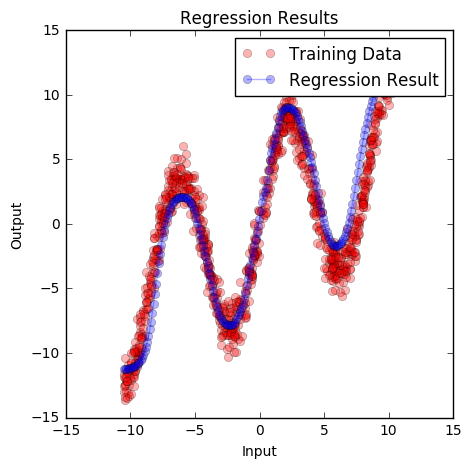

In [4]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size, 1)
y_test = sess.run(pred, feed_dict={x: x_test})

plt.figure(figsize=(5, 5))
plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.plot(x_test,y_test,'bo-',alpha=0.3)
plt.legend(["Training Data", "Regression Result"])
plt.title("Regression Results")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

## CLOSE SESSION

In [5]:
sess.close()
print ("SESSION CLOSED.")

SESSION CLOSED.


## GET NEW TRAINING DATA BY FLIPPING

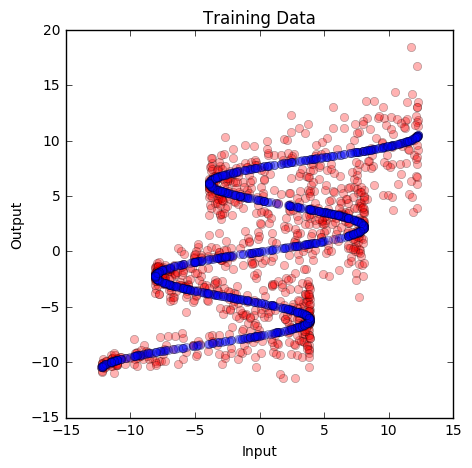

In [6]:
NSAMPLE = 1000
r_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
y_data = np.copy(r_data)
n_data = np.float32(np.random.normal(size=(NSAMPLE,1)))
x_data = np.float32(np.sin(0.75*y_data)*7.0 + y_data*0.5 + n_data*0.01)
for i in range(NSAMPLE): # ADD NOISE 
    y_data[i] = r_data[i] + 0.1*(x_data[i]+15)*n_data[i]
# PLOT
plt.figure(figsize=(5, 5))
plt.plot(x_data, y_data, 'ro', alpha=0.3)
plt.plot(x_data, r_data, 'bo', alpha=0.3)
plt.title("Training Data")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

## TRAIN NEW REGRESSION NETWORK

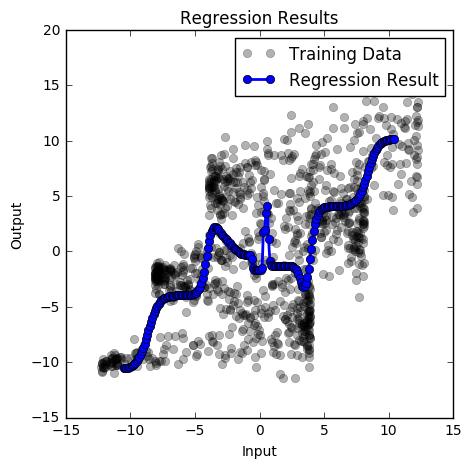

In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
NEPOCH = 1000
for i in range(NEPOCH):
    sess.run(optm, feed_dict={x: x_data, y: y_data})

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(pred, feed_dict={x: x_test})
# PLOT
plt.figure(figsize=(5, 5))
plt.plot(x_data, y_data,'ko',alpha=0.3)
plt.plot(x_test, y_test,'bo-',alpha=1,linewidth=2)
plt.legend(["Training Data", "Regression Result"])
plt.title("Regression Results")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

## CLOSE SESSION

In [8]:
sess.close()
print ("SESSION CLOSED")

SESSION CLOSED


## NOW, USE MIXTURE DENSITY NETWORK

In [9]:
NHIDDEN = 50
STDEV   = 0.1
KMIX    = 20 # NUMBER OF MIXTURES
NOUT    = KMIX * 3 # PI / MU / STD

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

NHIDDEN = 20
Wmdn = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
}
bmdn = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_uniform([1,NOUT], minval=-10, maxval=10, dtype=tf.float32))
}
def mdn(_x, _W, _b):
    sig_gain = 1
    _l1  = tf.nn.tanh(tf.matmul(_x, _W['l1']) + _b['l1'])
    _out = tf.matmul(_l1, _W['l2']) + _b['l2']
    # CONVERT OUTPUT
    _out_pi_hat, _out_sigma_hat, _out_mu = tf.split(_out, 3, 1)
    _out_pi_hat = tf.exp(_out_pi_hat - tf.reduce_max(_out_pi_hat, 1, keep_dims=True))
    _nor_pi = tf.reciprocal(tf.reduce_sum(_out_pi_hat, 1, keep_dims=True))
    _out_pi = tf.multiply(_nor_pi, _out_pi_hat)
    _out_sigma = sig_gain*tf.sigmoid(_out_sigma_hat)
    return _out_pi, _out_sigma, _out_mu
out_pi, out_sigma, out_mu = mdn(x, Wmdn, bmdn)
print ("MIXTURE DENSITY NETOWRK READY")

MIXTURE DENSITY NETOWRK READY


## SAMPLING FUNCTIONS

In [10]:
def get_pi_idx(_th, _pdf):
    accumulate = 0
    _pdf = _pdf + 0.0001
    _pdf = _pdf / np.sum(_pdf)
    for i in range(0, _pdf.size):
        accumulate += _pdf[i]
        if (accumulate >= _th):
            return i
    print ("error with sampling ensemble")
    return -1
def sample_gmm(_out_pi, _out_mu, _out_sigma, _M):
    NTEST  = _out_pi.shape[0]
    result = np.zeros((NTEST, _M))
    randns = np.random.randn(NTEST, _M) 
    for j in range(0, _M):
        for i in range(0, NTEST):
            idx = get_pi_idx(np.random.rand(), _out_pi[i])
            mu  = _out_mu[i, idx]
            std = _out_sigma[i, idx]
            result[i, j] = mu + randns[i, j]*std
    return result
print ("SAMPLING FUNCTION READY")

SAMPLING FUNCTION READY


## TRAIN

START OPTIMIZATION


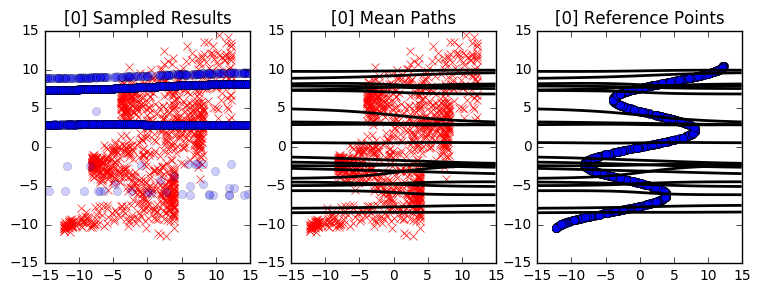

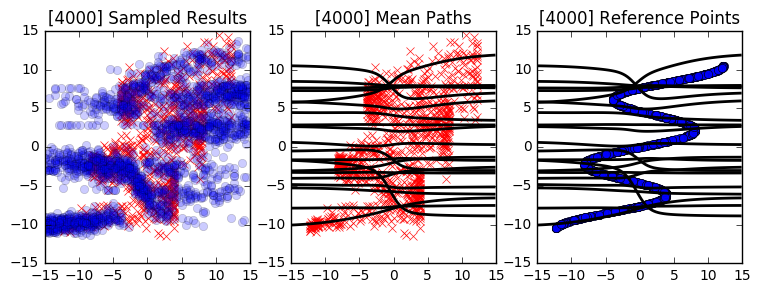

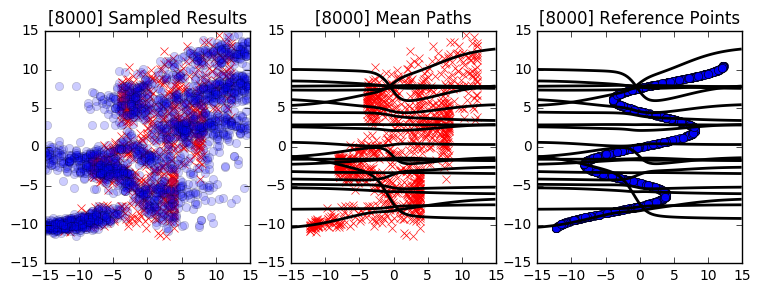

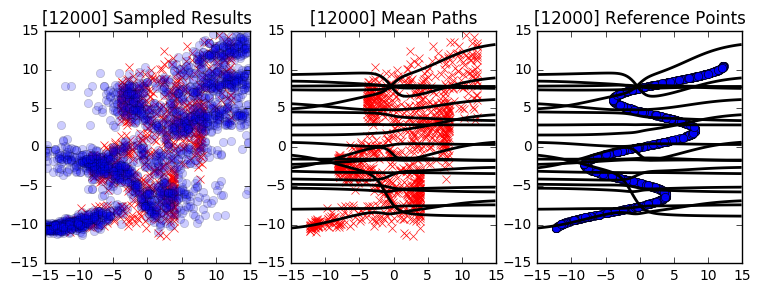

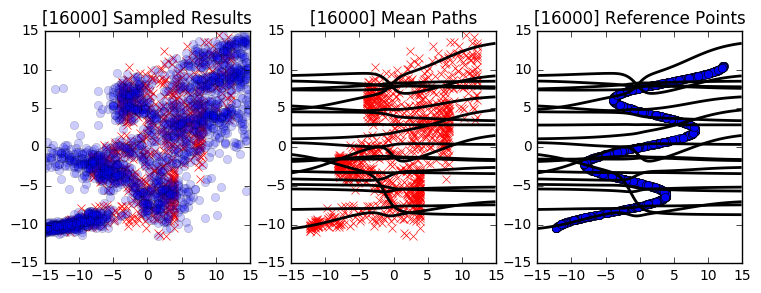

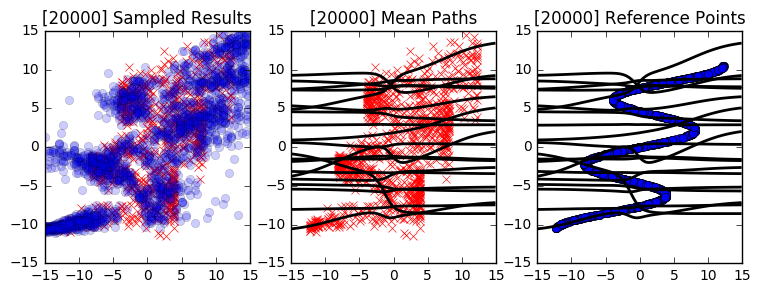

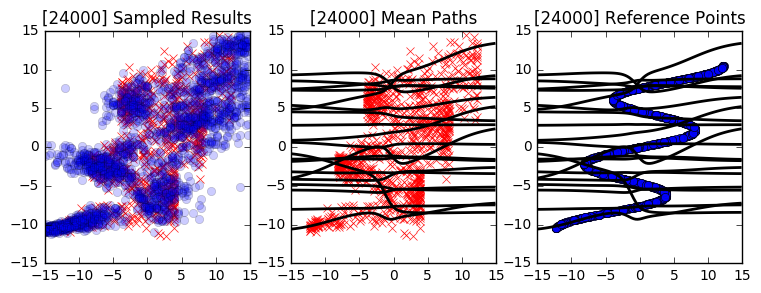

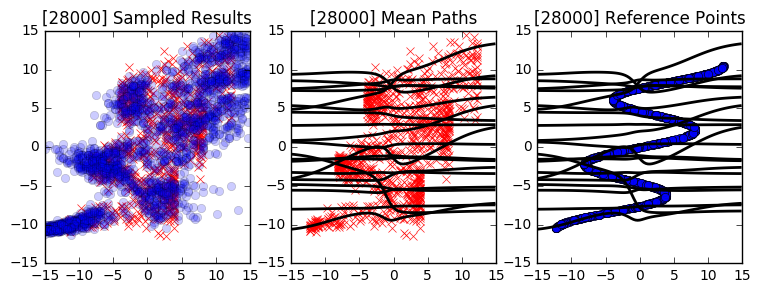

OPTIMIZATION FINISHED


In [11]:
pi = math.pi
# UNIVARIATE GAUSSIAN MODEL
def tf_normal(_y, _mu, _sigma):
    _result = (_y-_mu)/_sigma
    _result = -tf.square(_result)/2
    _result = tf.exp(_result)/(math.sqrt(2*pi)*_sigma)    
    return _result
# GAUSSIAN MIXTURE MODEL
def gmm(_y, _out_pi, _out_sigma, _out_mu):
    _probs = tf_normal(_y, _out_mu, _out_sigma)
    _result = tf.multiply(_out_pi, _probs)
    _result = tf.reduce_sum(_result, 1, keep_dims=True)
    return tf.reduce_mean(-tf.log(_result))

# SET LOSS AND OPTIMIZER
loss = gmm(y, out_pi, out_sigma, out_mu)
optm = tf.train.AdamOptimizer(learning_rate=0.001
            , beta1=0.9, beta2=0.999, epsilon=0.1).minimize(loss)

# OPEN SESSION
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 30000
losses = np.zeros(NEPOCH) # store the training progress here.
print ("START OPTIMIZATION")
for epoch in range(NEPOCH):
    feeds = {x: x_data, y: y_data}
    sess.run(optm, feed_dict=feeds)
    losses[epoch] = sess.run(loss, feed_dict=feeds)
    if (epoch%4000) == 0:
        x_sample = np.float32(np.arange(-15, 15, 0.3)).reshape(-1, 1)
        out_pi_test, out_sigma_test, out_mu_test \
            = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_sample})
        y_test = sample_gmm(out_pi_test, out_mu_test, out_sigma_test, KMIX)
        
        # PLOT
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(9, 3))
        ax1.plot(x_data, y_data, 'rx', alpha=0.9)
        ax1.plot(x_sample, y_test, 'bo', alpha=0.2)
        ax1.axis([-15, 15, -15, 15])
        
        ax1.set_title(("[%d] Sampled Results") % (epoch))
        ax2.plot(x_data, y_data, 'rx', alpha=0.9)
        ax2.plot(x_sample, out_mu_test, 'k-', linewidth=2.0, label="Mean Functions")
        ax2.set_title(("[%d] Mean Paths") % (epoch))
        ax2.axis([-15, 15, -15, 15])

        ax3.plot(x_data, r_data, 'bo', alpha=0.9)
        ax3.plot(x_sample, out_mu_test, 'k-', linewidth=2.0, label="Mean Functions")
        ax3.set_title(("[%d] Reference Points") % (epoch))
        ax3.axis([-15, 15, -15, 15])
        plt.show()
print ("OPTIMIZATION FINISHED")

## PLOT LOSS 

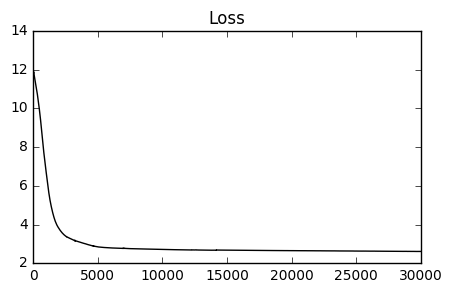

In [12]:
plt.figure(figsize=(5, 3))
plt.plot(losses, 'k-', alpha=1.0)
plt.title("Loss")

## PLOT SAMPLING RESULT

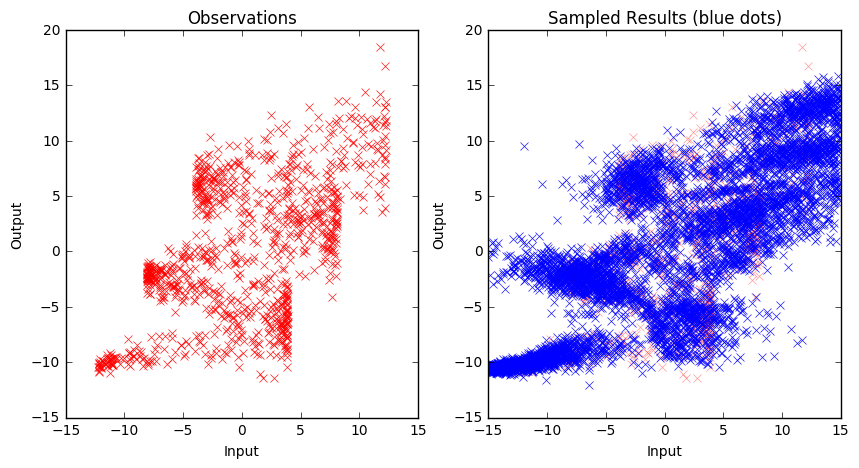

In [13]:
# SAMPLE
x_sample = np.float32(np.arange(-15,15,0.1)).reshape(-1, 1)
out_pi_test, out_sigma_test, out_mu_test \
    = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_sample})
y_test = sample_gmm(out_pi_test, out_mu_test, out_sigma_test, KMIX)

# PLOT
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 5))
ax1.plot(x_data, y_data, 'rx', alpha=0.9)
ax1.set_title("Observations")
ax1.set_xlabel("Input")
ax1.set_ylabel("Output")

ax2.plot(x_data, y_data, 'rx', alpha=0.4)
ax2.plot(x_sample, y_test, 'bx', alpha=0.9)
ax2.set_title("Sampled Results (blue dots)")
ax2.set_xlabel("Input")
ax2.set_ylabel("Output")

## PLOT MEAN FUNCTIONS

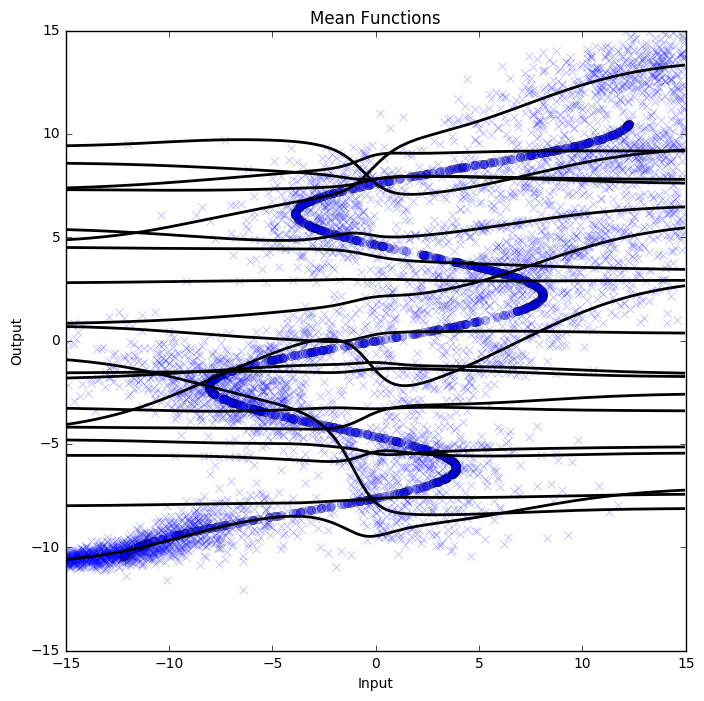

In [19]:
plt.figure(figsize=(8, 8))
p1=plt.plot(x_sample, y_test, 'bx', alpha=0.3, label="Sampling Result")
plt.plot(x_data, r_data, 'bo', alpha=0.3)
p2=plt.plot(x_sample, out_mu_test, 'k-', linewidth=2.0, label="Mean Functions")
plt.axis([-15, 15, -15, 15])
plt.title("Mean Functions")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

## PLOT HEATMAP

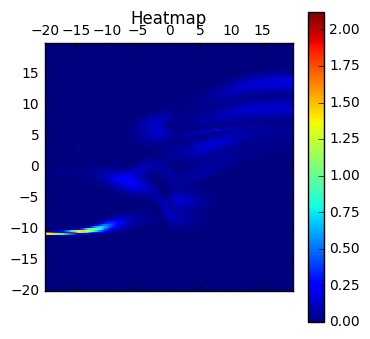

In [15]:
xgrid = np.float32(np.arange(-20, 20, 0.3))
ygrid = np.float32(np.arange(-20, 20, 0.3))

out_pi_grid, out_sigma_grid, out_mu_grid \
    = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: xgrid.reshape(-1, 1)})
def custom_gaussian(x, mu, std):
    x_norm = (x-mu)/std
    result = (1/math.sqrt(2*pi))*math.exp(-x_norm*x_norm/2)/std
    return result

def generate_heatmap(_out_pi, _out_mu, _out_sigma, _xgrid, _ygrid):
    N = _xgrid.size
    M = _ygrid.size
    z = np.zeros((N, M)) 
    for i in range(0, _out_pi.shape[0]):
        for k in range(0, _out_pi.shape[1]):
            pi, mu, std  = _out_pi[i, k], _out_mu[i, k], _out_sigma[i, k]
            for j in range(0, N): 
                z[N-j-1, i] += pi * custom_gaussian(_ygrid[j], mu, std)
    return z
def plot_heatmap(_xgrid, _ygrid, heatmap):
    _extent = [_xgrid[0], _xgrid[-1], _ygrid[0], _ygrid[-1]]
    plt.figure(figsize=(6, 6))
    plt.matshow(heatmap, extent=_extent)
    plt.colorbar()
    plt.title("Heatmap")
    plt.show()

z = generate_heatmap(out_pi_grid, out_mu_grid, out_sigma_grid \
                     , xgrid, ygrid)
plot_heatmap(xgrid, ygrid, z)